# Predicting Vaccination Rollout  

### Forecasting bulk and stratified vaccination numbers under a phased rollout approach 

##### Written by Chance Alvarado: [LinkedIn](https://www.linkedin.com/public-profile/in/chance-alvarado), [GitHub](https://github.com/chance-alvarado)
##### Explore the full repository [here](https://github.com/chance-alvarado/vaccination-rollout).

![Vaccine graphic](resources/vaccination_graphic.jpg)

Image courtesy of [Unsplash](https://unsplash.com/photos/DnBtFBnqlRc).

---

## Introduction

The COVID-19 pandemic and subsequent global rush for vaccination have placed healthcare providers into a once-in-a-lifetime situation of mass public vaccination. With limited availability and phased distribution, its is unclear when an acceptable proportion of the population will be vaccinated. The following notebook aims to generalize [The Center for Disease Control's](https://www.cdc.gov/coronavirus/2019-ncov/vaccines/recommendations.html) vaccine rollout guidelines and make predictions for a specified population (default being the state of Ohio).

### This notebook operates under the following assumptions

- Some proportion of the population will be ineligible to vaccinate. For example, children are currently unable to receive a COVID-19 vaccine. 

- Some proportion of the population will refuse the vaccine. These individuals are distributed uniformly across all groups.

- Vaccinations are administered at a constant rate daily. These rates are distributed in phases begining on some specified date.

- Individuals are stratified into mutually exclusive groups where they are teired by priority. The default is age but this need not be the case.

- Some proportion of the daily available doses are reserved for the highest priority group. Remaining daily doses 'trickle down'.

- The remaining available doses are uniformly distributed among remaining willing and eligible individuals. This can be used to simulate individuals receiving the vaccine due to their career or risk-status.

**Note: While current COVID-19 vaccines require two doses, we only forecast when individuals receive their first dose.**


---

## Imports

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

---

## Parameters

The following parameters can be modified to simulate varying vaccination dynamics in different populations. See this project's [README](https://github.com/chance-alvarado/vaccination-rollout/blob/main/README.md) for more details.

In [2]:
# Population of state
state_population = 11_690_000

# Percent of state eligible to vaccinate (i.e adults)
percent_eligible = 0.80

# Percent of population who will refuse vaccine
refusal_rate = 0.25

# Lists of phase start dates and daily vaccines linked by index
phase_dates = ['12/15/2020', '01/17/2021', '02/28/2021', '03/31/2021']
phase_daily_doses = [20_000, 25_000, 35_000, 50_000]

# Stratification of eligible as percent. Index impies priority. Should sum to 1.
stratification_labels = ['85+', '75-84', '65-74', '45-64', '25-44', '16-24']
stratification_proportions = [0.02, 0.07, 0.14, 0.34, 0.31, 0.12]

# Percent of doses in each phase to be alloted to priority group. Remaining 
priority_proportion = 0.9

---

## Population Breakdown

We first aim to visualize what proportion of our total population willing and eligible to receive a vaccine. We also aim to show the breakdown of the eligible population by stratified groups.

### Plot Results

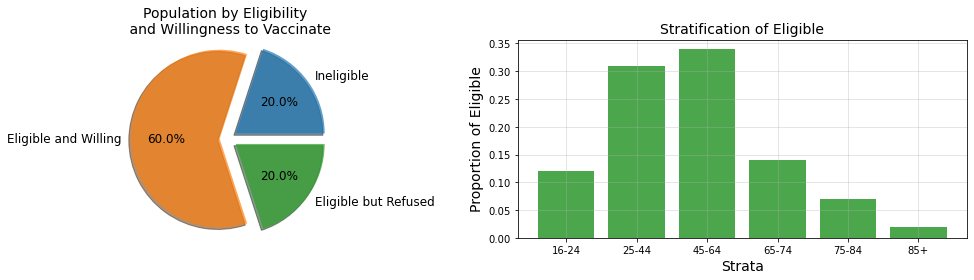

In [3]:
# Initialize figure
fig_pop, ax_pop = plt.subplots(nrows=1, ncols=2,
                               figsize=(14, 4),
                               gridspec_kw={'width_ratios': (1.5, 2)})

# Plot attributes
ax_pop[0].set_title('Population by Eligibility \n and Willingness to Vaccinate',
                    fontsize=14)
ax_pop[1].grid('On', alpha=0.4)
ax_pop[1].set_title('Stratification of Eligible', fontsize=14)
ax_pop[1].set_xlabel('Strata', fontsize=14)
ax_pop[1].set_ylabel('Proportion of Eligible', fontsize=14)

# Plot histogram of stratified population
ax_pop[1].bar(stratification_labels[::-1],
              stratification_proportions[::-1],
              color='g', alpha=0.7)

# Plot pie chart
pie = ax_pop[0].pie(
    [(1 - percent_eligible), (percent_eligible * (1 - refusal_rate)),
     (percent_eligible * refusal_rate)],
    labels=['Ineligible', 'Eligible and Willing', 'Eligible but Refused'],
    explode=[0.1, 0.1, 0.1], autopct='%1.1f%%',
    shadow=True, textprops={'fontsize': 12})

# Lower wedge opacity
for wedge in pie[0]:
    wedge.set_alpha(0.7)
    
# Ensure pie is drawn as a circle
ax_pop[0].axis('equal')

# Tight layout
fig_pop.tight_layout()

# Show plot
plt.show()

---

## Cumulative Vaccination by Day

Next, we show the cumulative first doses by date for the entire eligible and willing population. Vaccination phases are shown as well as the date in which all eligible and willing will be vacinated - the target date.

### Calculate cumulative doses by day and date when all willing have been vaccinated

In [4]:
# Convert date strings into datetime formats
phase_dates = [datetime.datetime.strptime(date, '%m/%d/%Y')
               for date in phase_dates]

# Find proportion of population eligible and willing
population_eligible_and_willing = int(state_population
                                      * percent_eligible
                                      * (1 - refusal_rate))

# List to hold doses by day
doses_by_day = []

# Loop through dates and assign values to doses by day
previous_date = phase_dates[0]
for date, rate_before_current_phase in zip(phase_dates[1:],
                                           phase_daily_doses[:-1]):
    doses_by_day += (date - previous_date).days * [rate_before_current_phase]
    previous_date = date

# Find difference between number willing and total vaccines
doses_still_needed = population_eligible_and_willing - sum(doses_by_day)

# Assign last phase doses if needed
if doses_still_needed > 0:
    days_still_needed = int(np.ceil(doses_still_needed
                                    / phase_daily_doses[-1]))
    doses_by_day += (days_still_needed) * [phase_daily_doses[-1]]

# Convert to cumulative sum
cumulative_doses = np.cumsum(doses_by_day)

# Floor number vaccinated at number willing and fetch first target day
target_date_index = np.argmax(
    cumulative_doses >= population_eligible_and_willing)
cumulative_doses[target_date_index:] = population_eligible_and_willing

# Append additional data points for plotting purposes
cumulative_doses = np.append(cumulative_doses,
                             10 * [population_eligible_and_willing])

### Plot Results

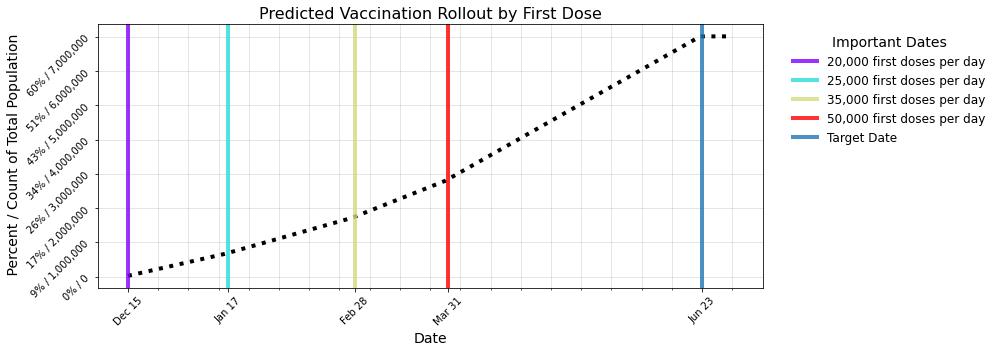

In [5]:
# Initialize figure 
fig_total, ax_total = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))

# Date range
date_range = [phase_dates[0] + datetime.timedelta(days=num_days)
              for num_days in range(len(cumulative_doses))]

# Plot attributes
ax_total.set_title('Predicted Vaccination Rollout by First Dose', fontsize=16)
ax_total.set_xlabel('Date', fontsize=14)
ax_total.set_ylabel(' Percent / Count of Total Population', fontsize=14)
ax_total.grid('On', alpha=0.4, which='both')

# Set xticks to highlight key dates
key_dates = phase_dates + [date_range[target_date_index]]
ax_total.set_xticks(date_range[::10], minor=True)
ax_total.set_xticks(key_dates)
ax_total.set_xticklabels([date.strftime('%b %d') for date in key_dates],
                         rotation=45)

# Plot cumulative first doses
plt.plot(date_range, cumulative_doses, lw=4, c='k', ls='dotted')

# Format yticks
ticks_loc = ax_total.get_yticks().tolist()
format_yticks = [f'{round(100 * count / state_population)}% / {int(count):,}'
                 for count in ax_total.get_yticks()] 
ax_total.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax_total.set_yticklabels(format_yticks, rotation=45)

# Specify unique color array
colors = plt.cm.rainbow(np.linspace(0,1,len(phase_dates)))

# Legend list 
legend_list = []

# Plot phase dates and append to list for legend
for date, color in zip(phase_dates, colors):
    line = ax_total.axvline(x=date, lw=4, c=color, alpha=0.8)
    legend_list.append(line)
    
# Plot target date and log for legend
line = ax_total.axvline(x=date_range[target_date_index], lw=4, alpha=0.8)
legend_list.append(line)

# Plot legend
ax_total.legend(handles=legend_list,
                labels=([f'{daily_dose:,} first doses per day'
                         for daily_dose in phase_daily_doses]
                         + ['Target Date']),
                 bbox_to_anchor=(1.03, 1),
                title='Important Dates',
                fontsize=12,
                title_fontsize=14,
                frameon=False
               )

# Apply tight layout
fig_total.tight_layout()

# Show plot
plt.show()

---

## Stratified Vaccinations by Day

Finally, we show cumulative first doses by each defined group in the population. 

### Find count of initial individuals by strata and calculate number of unvaccinated and willing by day

In [6]:
# Convert stratification proportions to number of individuals willing to vaccinate
stratification_counts = [state_population
                         * proportion * percent_eligible * (1-refusal_rate) 
 for proportion in stratification_proportions]

In [7]:
# Define function to generate next row of stratification data
def generate_next_stratification_row(available_doses, current_counts):
    """Generate next row in vaccination array by specified stratifiction"""
    # Number of priority doses form available doses
    priority_doses = priority_proportion * available_doses

    # Number of non-priority doses from available doses
    non_priority_doses = available_doses - priority_doses

    # List to hold counts of individuals after prioirty dose distribution
    next_day_counts = []

    # Number of stratifies groups
    num_priority_groups = len(stratification_counts)

    # Intialize remaining doses
    remaining_priority_doses = priority_doses
    
    # Index through all priority groups
    for priority_level in range(num_priority_groups):
        # Find remaining unvaccinated individuals in group. May be negative
        remaining_in_group = (current_counts[priority_level]
                              - remaining_priority_doses)

        # Append counts to list
        next_day_counts.append(max(remaining_in_group, 0))

        # Set remaining doses
        if remaining_in_group <= 0:
            remaining_priority_doses = -1 * remaining_in_group
        else:
            remaining_priority_doses = 0
     
    # Dirstibute non-prioirty doses equally among groups
    next_day_counts -= (
        np.array(next_day_counts) / max(sum(next_day_counts), 1)
        * non_priority_doses).astype(int)
    
    # Return counts for next day
    return next_day_counts

In [8]:
# Array to hold stratified counts by day
remaining_stratified_by_day = np.array(stratification_counts)

# Set current counts
current_counts = stratification_counts

# Index through list of doses by day 
for available_doses in doses_by_day:
    # Generate next row of data
    current_counts = generate_next_stratification_row(available_doses,
                                                      current_counts)
    
    # Append next row
    remaining_stratified_by_day = np.vstack((remaining_stratified_by_day,
                                             current_counts))
    
# Extend data for plotting purposes
last_row = remaining_stratified_by_day[-1, :]

for i in range(10):
    # Append next row
    remaining_stratified_by_day = np.vstack((remaining_stratified_by_day, 
                                            last_row))

### Plot Results

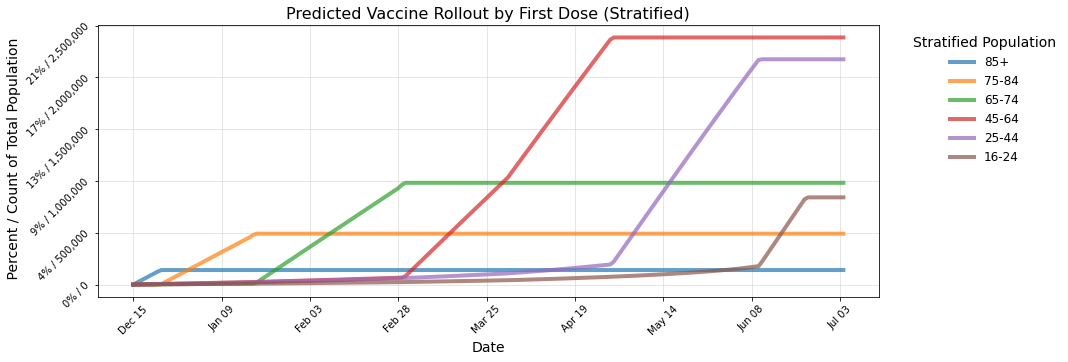

In [9]:
# Initialize figure 
fig_strat, ax_strata = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))

# Date range
date_range = [phase_dates[0] + datetime.timedelta(days=num_days)
              for num_days in range(len(remaining_stratified_by_day))]

# Plot attributes
ax_strata.set_title('Predicted Vaccine Rollout by First Dose (Stratified)',
                    fontsize=16)
ax_strata.set_xlabel('Date', fontsize=14)
ax_strata.set_ylabel(' Percent / Count of Total Population', fontsize=14)
ax_strata.grid('On', alpha=0.4, which='both')


# Format xticks
xspace = 25
format_xticks = [date.strftime('%b %d') for date in date_range[::xspace]]
ax_strata.set_xticks(date_range[::xspace])
ax_strata.set_xticklabels(format_xticks, rotation=45)

# Legend list
legend_list = []

# Plot stratified cumulative vaccinaitions and append to legend
for strata_index in range(len(stratification_labels)):
    line, = ax_strata.plot(date_range,
                  stratification_counts[strata_index]
                  - remaining_stratified_by_day[:, strata_index],
                 lw=4, ls='-', alpha=0.7)
    legend_list.append(line)
  
# Format yticks
ticks_loc = ax_strata.get_yticks().tolist()
format_yticks = [f'{round(100 * count / state_population)}% / {int(count):,}'
                 for count in ax_strata.get_yticks()] 
ax_strata.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax_strata.set_yticklabels(format_yticks, rotation=45)

# Plot legend
ax_strata.legend(handles=legend_list,
                labels=(stratification_labels),
                 bbox_to_anchor=(1.03, 1),
                title='Stratified Population',
                fontsize=12,
                title_fontsize=14,
                frameon=False
               )


# Apply tight layout
fig_total.tight_layout()

# Show plot
plt.show()

---